In [1]:
import numpy as np                         ## Used to create multidimensional array for creating / reading images
from PIL import Image as im                ## Used to read and write image data to / from files 
import base64                              ## Used to convert the base64 output of encryption to hexadecimal
from Crypto.Util.Padding import pad, unpad ## Pads the data to a multiple 16 bytes for encryption
from Crypto.Cipher import AES              ## Used to perform AES encryption on the image data
import os                                  ## Used to generate random numbers for encryption
import cv2                                 ## Used to combine images into a video and break videos up into frames
from IPython.display import display        ## Used to display the images in the notebook for demonstration

In [2]:
def encrypt_image_to_B16(image_name, key, nonce):
    """
    Perform AES encryption on an image 
    
    Args: 
        image_name: The path to the image that is to be encrypted.
        key: AES encryption key.
        nonce: AES encryption nonce.
    Returns:
        Hexadecimal encoding of the image data after it has been encrypted with the given AES key and nonce.
    """
    
    block_size = 16
    
    ## To display the image in the notebook
    print("The image that will be encrypted and stored as a video: ")
    image_display = im.open(image_name)
    display(image_display)
    
    ## Reading in the image data, padding it to 16 bytes and encrypting it using the passed key and nonce
    with open(image_name, "rb") as image:
        data_to_encrypt = image.read()
        cipher = AES.new(key, AES.MODE_CBC, nonce)
        cipher_text = cipher.encrypt(pad(data_to_encrypt, 16))
    return base64.b16encode(cipher_text)

In [3]:
def encrypted_to_binary_string(encrypted_image_hex):
    """
    Convert the encrypted string from hex to binary.
    
    Args:
        encrypted_image_hex: A string of hexadecimal characters that encodes the encrypted imager data, 
                             ouput of encrypt_image_to_B16()
    Returns:
        output_string: The binary encoding of the passed in hex string
    """
    
    output_string = ""
    bin_char_dict = {0: "0", 1: "1", 2:"10", 3: "11", 4: "100", 5: "101", 6: "110", 7: "111", 
                  8: "1000", 9: "1001", 10: "1010", 11: "1011", 12: "1100", 13: "1101", 14: "1110",
                  15: "1111"}
    
    ## Looping over all the hex values in the argument, and using their ascii values to get the corrosponding
    ## binary bits. 
    for ascii_val in encrypted_image_hex:
        if (ascii_val > 57):
            output_string += bin_char_dict[ascii_val - 55].zfill(4)
        else:
            output_string += bin_char_dict[ascii_val - 48].zfill(4)
    return output_string

In [4]:
def binary_string_to_images(binary_string):
    """
    Creates the images to encode the data stored in the binary string. A white pixel is the encoding for a 1
    while a black pixel is the encoding for a 0. Since all the images are of the same size, the images are
    padded to the appropriate size using gray pixels. 
    
    Args:
        binary_string: The string of binary characters to be encoded into the images (not a bytes object). 
    Returns:
        created_images: A list of the paths (in this case just the names since they are created in the same 
        folder) of the created images.
    """
    
    editable_string = binary_string ##Copy made so that the arguments are not changed
    created_images = []
    images_made_count = 0
    
    ## Each frame in the video will have a fixed size of 360 x 512
    pixel_array = np.arange(0, 512*360, 1, np.uint8)
    pixel_array = np.reshape(pixel_array, (360, 512))
    
    ## The while loop condition holds true when there is more than 1 image worth of data to encode. The bits
    ## are read in one at a time and are placed into the array. The indexing is done as shown below because
    ## the count is kept in essentially 1 dimension, but it is a 2 dimensional array. 
    
    while (len(editable_string) >= 512 * 360):
        count = 0
        for binaryBit in editable_string[:512*360]:
            pixel_array[count // 512][count - ((count // 512) * 512)] = 255 if int(editable_string[count]) else 0
            count += 1
        data = im.fromarray(pixel_array)
        data.save(str(images_made_count) + '.png')
        created_images.append(str(images_made_count) + '.png')
        images_made_count += 1
        editable_string = editable_string[512*360:]
    count = 0
    
    ## Once there is less than 1 image (512 * 360 bits) of data, then loop over the remaining bits and fill
    ## them in the same way. Then the remaining pixels are filled in with a gray color. 
    for binaryBit in editable_string:
        pixel_array[count // 512][count - ((count // 512) * 512)] = 255 if int(editable_string[count]) else 0
        count += 1
    while (count < 512 * 360):
            pixel_array[count // 512][count - ((count // 512) * 512)] = 127
            count += 1
    data = im.fromarray(pixel_array)
    data.save(str(images_made_count) + '.png')
    created_images.append(str(images_made_count) + '.png')
    images_made_count += 1
    return created_images

In [5]:
def convert_images_to_video(created_images):
    """
    Combines all the created images into an avi video. 
    
    Args:
        created_images: A list of all the images that need to be combined. Output of binary_string_to_images().
    Returns:
        No return value.
    """
    ## More information about why I have chosen the AVI format is available in the README. I chose a framerate
    ## of 0.5 (i.e. one frame every two seconds) for the sake of the demonstration, in reality the frame rate
    ## can be decided by the storage service of choice. 
    video_stream = cv2.VideoWriter("newlyCreatedVideo.avi", cv2.VideoWriter_fourcc(*"DIVX"), 0.5, (512, 360))
    for frame in created_images:
        video_stream.write(cv2.imread(frame))
    video_stream.release()
    print(f"newlyCreatedVideo.avi created from {len(created_images)} frames")

In [6]:
def closer_to_which(value):
    """
    Part of the decryption process; takes in the colour value of a pixel and finds which of the 3 possible
    values (0, 127, 255) it is closest to. Required due to the probablistic nature of conversion (more 
    information in README)
    
    Args:
        value: The color value of the pixel
    Returns:
        The color value of the pixel that it is closest to (either 0, 127, or 255)
    """
    if (value < 64):
        return 0
    if (value > 190):
        return 255
    return 127

In [7]:
def video_to_original_images(video_name):
    """
    During the encoding to a video, the images that were combined into a video are now broken up from the 
    video back into the original images before decoding and decryption. 
    
    Args:
        video_name: The path to the video that encodes the data
    Returns:
        frames: A list of the paths (just the names in this case because they are all stored in the same 
        folder) to the images that the video is broken into.
    """
    frames = []
    video_capture = cv2.VideoCapture(video_name)
    success, frame = video_capture.read()
    frame_count = 0
    
    ## The condition for the while loop to be entered is whether or not a frame was succesfully read. If 
    ## once a frame is read, then a blank (it is filled with values but those are written over) array of 
    ## the required size is created, and based on the closer_to_which() return value the array is filled with
    ## the pixel values. 
    
    while success: 
        frame = np.asarray(frame)
        recreated_frame = np.arange(0, 512*360, 1, np.uint8)
        recreated_frame = np.reshape(recreated_frame, (360, 512))
        count = 0
        for row in frame:
            for column in row:
                recreated_frame[count // 512][count - ((count // 512) * 512)] = closer_to_which(column[0])
                count += 1
        cv2.imwrite(f"frame{frame_count}.png", recreated_frame) 
        frames.append(f"frame{frame_count}.png")
        frame_count += 1
        success,frame = video_capture.read()
    
    return frames

In [8]:
def frames_to_binary_string(created_frames):
    """
    The images that were later combined into a video encode the values stored in a string of binary characters.
    The images that are broken up from the video are now converted back to that binary string that was passed
    in. 
    
    Args:
        created_frames: A list of the paths to the frames that are broken up from the video (output of 
        video_to_original_images()).
    Returns:
        binary_string: A string (not a bytes object) of binary characters that encodes the encrypted 
        image data. 
    """
    ## Looping over all the frames, the value for each pixel is read and filled in as either a 0 or a 1
    ## into the newly created binary string. Once a value that is not 0 or 255 is reached, we have reached
    ## the filler values and the loop stops running. 
    binary_string = ""
    for frame_name in created_frames:
        current_frame_image = im.open(frame_name)
        current_frame = np.asarray(current_frame_image)
        for row in current_frame:
            for pixel in row:
                if(pixel == 255):
                    binary_string += "1"
                elif(pixel == 0):
                    binary_string += "0"
                else:
                    break
    return binary_string

In [9]:
def binary_to_decryptable_image_hex(binary_string):
    """
    The binary string was originally a hexadecimal string that was then converted into a string of binary
    characters. This function converts the binary_string that we get from frames_to_binary_string() back
    to the original string of only hexadecimal characters. 
    
    Args:
        binary_string: The string of binary characters that is to be decoded. 
    Returns:
    hex_string: A string of only hexadecimal characters. 
    """
    
    ## 4 binary bits corrospond to 1 hexadecimal character. So, reading in the string 4 characters at a time, 
    ## and using the dictionary for the appropriate hexadecimal value (stored as a bytes object for decryption).
    
    test_string = binary_string ## Copy to avoid editing arguments
    remaining_chars = len(binary_string) / 4
    hex_string = b""
    hex_dict = {"0000": b"0", "0001": b"1", "0010": b"2", "0011": b"3","0100": b"4", "0101": b"5", 
          "0110": b"6", "0111": b"7","1000": b"8", "1001": b"9","1010": b"A", "1011": b"B",
          "1100": b"C", "1101": b"D", "1110": b"E", "1111": b"F"}
    while remaining_chars > 0:
        hex_string += hex_dict[test_string[:4]]
        test_string = test_string[4:]
        remaining_chars -= 1
    return hex_string

In [10]:
def decrypt_image_from_B16(encrypted_image_hex, key, nonce):
    """
    The original image was encrypted and the output was a bytes object (b"...") of hexadecimal characters, here
    the hexadecimal string is decrypted and converted back into an image. 
    
    Args:
        encrypted_image_hex: The bytes object containing the encrypted image data
        key: The AES encryption key
        nonce: the AES encryption nonce
    Returns:
        No return value. 
    """
    ## Once the original hexadecimal string is recreated, it must be converted back to the base64 output of
    ## the encryption function, and it can then be decrypted back into the image data which is writen to a file.
    decryptable_string = base64.b16decode(encrypted_image_hex)
    decryption_cipher = AES.new(key, AES.MODE_CBC, nonce)
    decrypted_data = unpad(decryption_cipher.decrypt(decryptable_string), 16)
    with open("decryptedFile.jpg", "wb") as output_file:
        output_file.write(decrypted_data)
    print("decryptedFile.jpg: ")
    image = im.open("decryptedFile.jpg")
    display(image)

In [11]:
def main():
    """
    Calls all the encryption + encoding, and decryption + decoding functions. Generates the key and nonce 
    for encryption which it passes to the functions where it is required. This will be changed in the future, 
    more information can be found in the README.
    
    Args:
        Takes no arguments. 
    Returns:
        No return value. 
    """
    
    key = os.urandom(16)
    nonce = os.urandom(16)
    ##Encryption
    encrypted_image_hex = encrypt_image_to_B16("originalImage.jpg", key, nonce)
    binary_string = encrypted_to_binary_string(encrypted_image_hex)
    created_images = binary_string_to_images(binary_string)
    convert_images_to_video(created_images)
    
    ##Decryption
    created_frames = video_to_original_images("newlyCreatedVideo.avi")
    recreated_binary_string = frames_to_binary_string(created_frames)
    decryptable_image_hex = binary_to_decryptable_image_hex(recreated_binary_string)
    decrypt_image_from_B16(decryptable_image_hex, key, nonce)

The image that will be encrypted and stored as a video: 


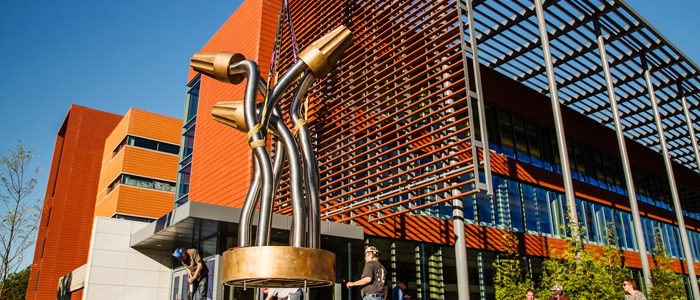

newlyCreatedVideo.avi created from 4 frames
decryptedFile.jpg: 


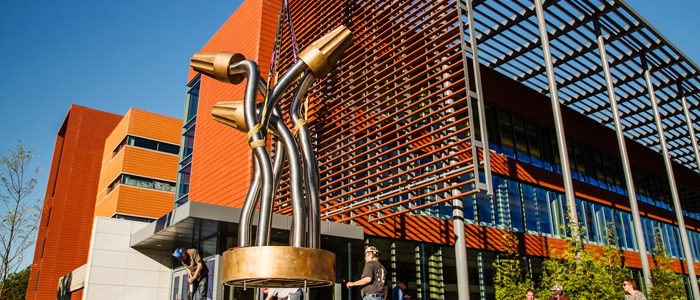

In [12]:
main()